In [2]:
import cv2 
import cv2.aruco as aruco

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.insert(0, "..")
from camera import Camera

pybullet build time: Jun  1 2023 12:35:10


In [5]:
cam_id = 0
capture = cv2.VideoCapture(cam_id)

In [6]:
# capture.release()

In [7]:
res = (1280, 720)
res_x, res_y = res
capture.set(3, res_x)
capture.set(4, res_y)
capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"MJPG"))

True

In [8]:
from pathlib import Path

def get_path(path):
    path = Path(path)
    if not path.exists():
        return path
    raise ValueError("File Exists!")

In [9]:
board = aruco.CharucoBoard((5, 4), 20, 10,
                           aruco.getPredefinedDictionary(aruco.DICT_4X4_50))

In [12]:
aruco.CharucoDetector(board)

TypeError: CharucoDetector() missing required argument 'board' (pos 1)

In [40]:
from PIL import Image as im
import io
import cv2
import numpy as np
import cv2.aruco as aruco
import os
import time

TILE_SIZE = .2391 / 8
MARKER_SIZE = TILE_SIZE * 23 / 30
class Camera:

    def __init__(self, tile_size=TILE_SIZE, marker_size=MARKER_SIZE,
                 board_size=(5,8),):
        self.captured_images = []
        
        self.dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
        self.parameters =  aruco.DetectorParameters()
        self.charuco_params = aruco.CharucoParameters()
        
        self.tile_size = tile_size
        self.board = aruco.CharucoBoard(board_size, self.tile_size, marker_size,
                                        self.dictionary)
        self.board.setLegacyPattern(True)
        self.detector = aruco.CharucoDetector(self.board, self.charuco_params, self.parameters)
        
        self.mtx, self.dist = None, None
        self.captured_images = []
        self.last_time = 0

    def add_frame(self, image) -> np.ndarray:
        """
        returns RGBA array of size (x, y, 4)
        """
        image0 = image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        cur_corners, cur_ids, _ = self.detector.detectMarkers(image)
        
        if time.time() - self.last_time < 0.5:
            cv2.circle(image0,(1150, 700), 10, (255, 255, 0),
                       int(np.sin(time.time() - self.last_time) * 40) + 1)
        elif len(cur_corners) >= 19:
            cv2.circle(image0,(1200, 700), 10, (255, 255, 0), 2)
            self.captured_images.append(image0.copy())
            self.last_time = time.time()
            
        cv2.putText(image0, f"{len(cur_corners):02d}", (64,64), font, 1, (0,255,0),2,cv2.LINE_AA)
        return image0
    
    def load_coeffs(self):
        self.mtx = np.array([[1.11297931e+03, 0.00000000e+00, 6.40000000e+02],
                             [0.00000000e+00, 1.11297931e+03, 3.60000000e+02],
                             [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
        self.dist = np.zeros((1, 5))

    
    def calibrate(self):
        matched_points = []
        for image in self.captured_images:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cur_corners, cur_ids, *_ = self.detector.detectBoard(image)
            if cur_ids is not None:
                matched_points.append(list(
                    map(np.squeeze, self.board.matchImagePoints(cur_corners, cur_ids.flatten()))
                ))
        obj_points, img_points = zip(*matched_points)
        print(obj_points[1].shape, len(img_points), obj_points[0].shape, img_points[0].shape)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            obj_points, img_points, image.shape,
            None, None
        )
        self.mtx = mtx
        self.dist = dist
        print()
        print(self.mtx, self.dist)
        print()
    
    def process_charuko(self, frame):
        assert self.mtx is not None and self.dist is not None
        
        frame = frame.copy()
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        corners, ids, _ = self.detector.detectMarkers(gray)
        
        if not len(corners):
            # cv2.putText(frame, "No Ids", (0,64), font, 1, (0,255,0),2,cv2.LINE_AA)
            return frame, None, None
        
        _, corners_checker, ids_checker = aruco.interpolateCornersCharuco(
            corners, ids,
            gray, self.board
        )
        
        _, rvec_check, tvec_check = aruco.estimatePoseCharucoBoard(
            corners_checker, ids_checker, 
            self.board, self.mtx, self.dist,
            None, None
        )
        try:
            cv2.drawFrameAxes(frame, self.mtx, self.dist, rvec_check, tvec_check, 0.1)
        except:
            pass
        # print(rvec_check, tvec_check)
        aruco.drawDetectedMarkers(frame, corners)
        rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, self.tile_size / 2, self.mtx, self.dist)
        # print()
        # print(rvecs[0], tvecs[0])
        
        for rvec, tvec in zip(rvecs, tvecs):
            cv2.drawFrameAxes(frame, self.mtx, self.dist, rvec, tvec, 0.01)
            
        return frame, rvec_check, tvec_check


In [42]:
calibr = Camera(board_size=(5, 8))
calibr.load_coeffs() 
with open("./data/images_1.npy", "rb") as f:
    calibr.captured_images.extend(list(np.load(f)))
with open("./data/images_2.npy", "rb") as f:
    calibr.captured_images.extend(list(np.load(f)))

In [43]:
calibr.calibrate()

(26, 3) 120 (26, 3) (26, 2)


error: OpenCV(4.8.0) /home/conda/feedstock_root/build_artifacts/libopencv_1694892512582/work/modules/calib3d/src/calibration.cpp:1173: error: (-2:Unspecified error) in function 'void cvFindExtrinsicCameraParams2(const CvMat*, const CvMat*, const CvMat*, const CvMat*, CvMat*, CvMat*, int)'
> DLT algorithm needs at least 6 points for pose estimation from 3D-2D point correspondences. (expected: 'count >= 6'), where
>     'count' is 4
> must be greater than or equal to
>     '6' is 6


In [12]:
calibr.calibrate()

19 (1, 4, 2) (19, 1)
19 (1, 4, 2) (19, 1)
19 (1, 4, 2) (19, 1)
19 (1, 4, 2) (19, 1)
20 (1, 4, 2) (20, 1)
20 (1, 4, 2) (20, 1)
20 (1, 4, 2) (20, 1)
19 (1, 4, 2) (19, 1)
20 (1, 4, 2) (20, 1)
20 (1, 4, 2) (20, 1)
17 (1, 4, 2) (17, 1)
15 (1, 4, 2) (15, 1)
13 (1, 4, 2) (13, 1)
20 (1, 4, 2) (20, 1)
19 (1, 4, 2) (19, 1)
20 (1, 4, 2) (20, 1)
20 (1, 4, 2) (20, 1)
20 (1, 4, 2) (20, 1)
16 (1, 4, 2) (16, 1)
17 (1, 4, 2) (17, 1)
20 (1, 4, 2) (20, 1)
13 (1, 4, 2) (13, 1)
17 (1, 4, 2) (17, 1)
6 (1, 4, 2) (6, 1)
5 (1, 4, 2) (5, 1)
11 (1, 4, 2) (11, 1)
9 (1, 4, 2) (9, 1)
9 (1, 4, 2) (9, 1)
13 (1, 4, 2) (13, 1)
12 (1, 4, 2) (12, 1)
20 (1, 4, 2) (20, 1)
19 (1, 4, 2) (19, 1)
20 (1, 4, 2) (20, 1)
19 (1, 4, 2) (19, 1)
13 (1, 4, 2) (13, 1)
17 (1, 4, 2) (17, 1)
20 (1, 4, 2) (20, 1)
17 (1, 4, 2) (17, 1)
18 (1, 4, 2) (18, 1)
19 (1, 4, 2) (19, 1)
18 (1, 4, 2) (18, 1)
18 (1, 4, 2) (18, 1)
19 (1, 4, 2) (19, 1)
20 (1, 4, 2) (20, 1)
19 (1, 4, 2) (19, 1)
15 (1, 4, 2) (15, 1)
20 (1, 4, 2) (20, 1)
12 (1, 4, 2) (12, 1)


KeyboardInterrupt: 

In [11]:
with open("./data/images_2.npy", "rb") as f:
    imgs = np.load(f)

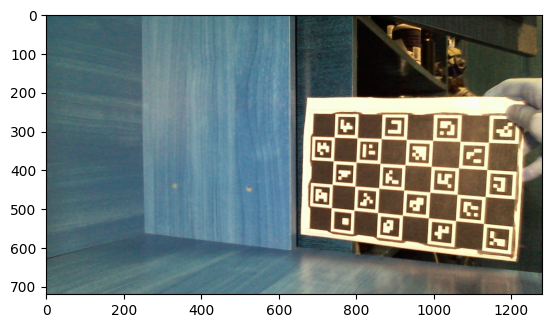

In [14]:
import matplotlib.pyplot as plt
plt.imshow(imgs[10])

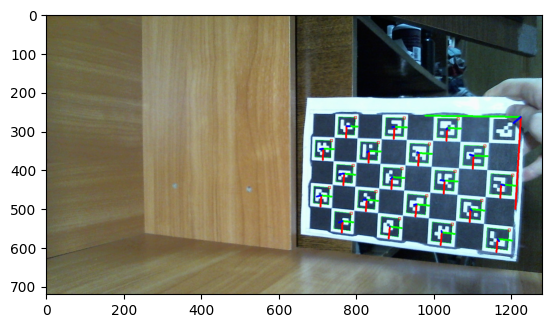

In [15]:
plt.imshow(calibr.process_charuko(imgs[10])[0][:, :, [2, 1, 0]])

In [177]:
_, cam_img = capture.read()

Corrupt JPEG data: 4 extraneous bytes before marker 0xd6


In [183]:
cam_img.shape

(720, 1280, 3)

In [54]:
def _stream():
    displaying = np.array([])
    is_calibrating = False
    while True:
        _, cam_img = capture.read()
        if not displaying.size:
            if is_calibrating:
                image = calibr.add_frame(cam_img)
                cv2.circle(image,(1200, 20), 10, (0, 0, 255), 10)
                cv2.imshow('w', image)
            else:
                cv2.imshow('w', cam_img)
        else:
            cv2.imshow('w', calibr.process_charuko(cam_img)[0])
        
        if (key := cv2.waitKey(1)) == ord("q"):
            break
        elif key == ord("n"):
            if not displaying.size:
                displaying = calibr.process_charuko(cam_img)[0]
            else:
                displaying = np.array([])
        elif key == ord("z"):
            calibr.calibrate()
        elif key == ord("c"):
            is_calibrating = not is_calibrating
def stream():
    try:
        _stream()
    finally:
        cv2.destroyAllWindows()

In [106]:
from pathlib import Path

def get_path(path):
    path = Path(path)
    if not path.exists():
        return path
    raise ValueError("File Exists!")

In [ ]:
stream()

In [96]:
len(calibr.captured_images)

133

In [97]:
calibr.calibrate()


[[4.95000768e+03 0.00000000e+00 4.10762718e+02]
 [0.00000000e+00 2.60416955e+03 7.23168423e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[   0.4552837    28.86746999    0.4017428    -0.17387608 -146.86788113]]



In [78]:
image = cv2.cvtColor(cam_img, cv2.COLOR_BGR2GRAY)

In [79]:
cur_corners, cur_ids, _ = detector.detectMarkers(image)

In [80]:
len(cur_corners)

0

In [83]:
_

(array([[[260., 239.],
         [257., 243.],
         [232., 253.],
         [239., 246.]]], dtype=float32),
 array([[[1112.,  320.],
         [1108.,  351.],
         [1098.,  368.],
         [1104.,  321.]]], dtype=float32),
 array([[[523., 235.],
         [539., 247.],
         [549., 260.],
         [524., 239.]]], dtype=float32),
 array([[[290., 224.],
         [264., 239.],
         [267., 232.],
         [286., 223.]]], dtype=float32),
 array([[[235.,  86.],
         [298.,  95.],
         [311., 109.],
         [235., 101.]]], dtype=float32))

Corrupt JPEG data: 1 extraneous bytes before marker 0xd4


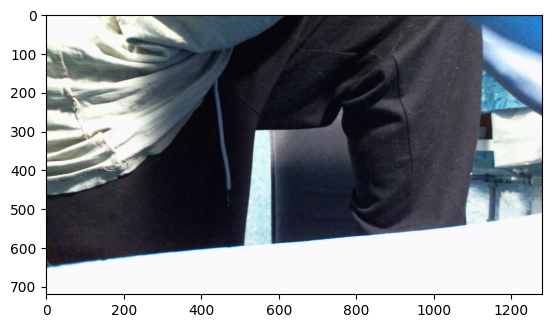

In [75]:
import matplotlib.pyplot as plt
_, cam_img = capture.read()
plt.imshow(cam_img)

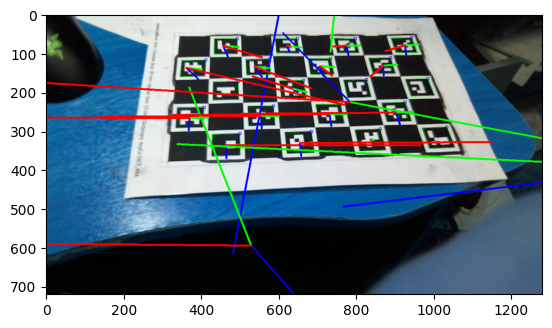

In [81]:
plt.imshow(calibr.process_charuko(cam_img)[0])

In [ ]:
def disl_charuco():
    displaying = np.array([])
    try:
        while True:
            _, cam_img = capture.read()
            
            if not displaying.size:
                cv2.imshow('w', cam_img)
            else:
                cv2.imshow('w', displaying)
            if (key := cv2.waitKey(1)) == ord("q"):
                break
            elif key == ord("t"):
                calibr.get_frame()
            elif key == ord("f"):
                displaying = calibr.process_charuko(cam_img)
    finally:
        cv2.destroyAllWindows()

In [38]:
len(calibr.captured_images)

24

In [ ]:
calibr.stream()

In [8]:
chr(123)

'{'